# [Dacon LG SYSTEM]

*LeeDongGyu*

# Contents
---

Multiclass
```
1) LightGBM
2) CatBoost
3) MLP
4) Model Ensemble
```




In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Packages


In [ ]:
#pip install pycaret

In [2]:
pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-cp36-none-any.whl size=11685 sha256=5735900bbcf9c0528fdfcf7aed6dc0e0afeca9489ff78c7a03ff6df639fb41e3
  Stored in directory: /root/.cache/pip/wheels/5a/56/ae/e0e3c1fc1954dc3ec712e2df547235ed072b448094d8f94aec
Successfully built bayesian-optimization


In [3]:
pip install catboost

     |████████████████████████████████| 65.8MB 64kB/s 


# Modules

In [4]:
cd /content/drive/My Drive/Colab Notebooks/DACON/LG_SYSTEM

/content/drive/My Drive/Colab Notebooks/DACON/LG_SYSTEM


In [5]:
#from pycaret.classification import *
from bayes_opt import BayesianOptimization
import pandas as pd
import numpy as np
import gc
import os
import random
import matplotlib.pyplot as plt

import joblib # 모형 저장 및 불러오기 관련 모듈
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action='ignore')



PATH = './data/'
current_day='0131(현재 최고)'
np.random.seed(0)
random.seed(0)

In [6]:
# 딥러닝 관련 모듈

import tensorflow as tf
from tensorflow import keras as ks
from tensorflow.keras import backend as K 
from tensorflow.keras.layers import Dense, Dropout, Activation, Input, LeakyReLU, BatchNormalization, add
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.utils import plot_model , to_categorical, get_file
from sklearn.preprocessing import StandardScaler

import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/Paper')
import utils
import optimizers_v2
from utils import get_weight_decays, fill_dict_in_order
from utils import reset_seeds, K_eval
from optimizers_v2 import AdamW
from f1score import macro_f1score

# Multiclass(LightGBM+CatBoost+CNN) 

In [ ]:
##################################################################################################################################
###################### Bayesian Optimization를 사용하여, 각 머신러닝 모형에 대해 하이퍼파라미터를 접근한다. ######################
##################################################################################################################################

## 1) LightGBM

In [7]:
### 데이터 부르기 
train_x=np.loadtxt(os.path.join(current_day,'x_train.csv'))
train_y=np.loadtxt(os.path.join(current_day,'y_train.csv')).astype(int)
X_test=np.loadtxt(os.path.join(current_day,'x_test.csv'))

tp='multi'

In [ ]:
# 목적함수 정의.
def lgbm_cv(learning_rate, 
            num_iterations,
            early_stopping_round,
            max_depth, 
            feature_fraction, 
            scale_pos_weight
            ):
  
  n_splits=5
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
  auc=[]
  params = {}
  params['learning_rate'] = learning_rate
  params['num_iterations'] = int(num_iterations)
  params['early_stopping_round'] = int(early_stopping_round)
  params['max_depth'] = int(max_depth)
  params['feature_fraction'] = feature_fraction
  params['scale_pos_weight'] = scale_pos_weight


  for tr_ind, val_ind in skf.split(train_x , train_y):
      X_train = train_x[tr_ind]
      y_train = train_y[tr_ind]
      X_valid = train_x[val_ind]
      y_valid = train_y[val_ind]
      lgbm_clf = LGBMClassifier(**params,
                              objective='multiclass',
                              random_state=1111
                              )
      
      lgbm_clf.fit(X_train, y_train,eval_set=(X_valid, y_valid),verbose = False) # 모형적합
    

      y_pred = lgbm_clf.predict(X_valid)
      y_pred_proba=lgbm_clf.predict_proba(X_valid)

      # 결과값에 대해서 binary로 변환
      binary_y_valid=np.array([1 if i>=1 else 0 for i in y_valid])
      binary_y_pred_proba=1-y_pred_proba[:,0] #1 - 문의를 보내지 않을 확률 == 1번이라도 문의를 보낼 확률
      
      # auc저장
      auc_value = roc_auc_score(binary_y_valid, binary_y_pred_proba)
      auc.append(auc_value)

  return sum(auc)/n_splits

In [ ]:
pbounds = {'learning_rate' : (0.001, 0.1),
           'num_iterations' : (300, 800),
           'early_stopping_round' : (100,150),
           'max_depth': (10,20),
           'feature_fraction': (0.7, 0.95),
           'scale_pos_weight' : (1.1,1.5)
          }

In [ ]:
# 객체 생성
lgbm_BO = BayesianOptimization(f = lgbm_cv, pbounds = pbounds, verbose = 2, random_state = 1234 )

In [ ]:
# 베이지안 최적화 시작
lgbm_BO.maximize(init_points=3, n_iter = 20, acq='ei', xi=0.01) 

|   iter    |  target   | early_... | featur... | learni... | max_depth | num_it... | scale_... |
-------------------------------------------------------------------------------------------------
|  1        |  0.8244   |  109.6    |  0.8555   |  0.04434  |  17.85    |  690.0    |  1.209    |
|  2        |  0.8243   |  113.8    |  0.9005   |  0.09586  |  18.76    |  478.9    |  1.3      |
|  3        |  0.8242   |  134.2    |  0.8782   |  0.03765  |  15.61    |  551.5    |  1.106    |
|  4        |  0.824    |  100.2    |  0.9031   |  0.04599  |  14.3     |  301.7    |  1.499    |
|  5        |  0.8243   |  149.7    |  0.8335   |  0.03561  |  12.12    |  799.2    |  1.229    |
|  6        |  0.8245   |  149.3    |  0.8238   |  0.02855  |  13.18    |  300.3    |  1.488    |
|  7        |  0.8241   |  100.7    |  0.8252   |  0.07287  |  12.36    |  797.3    |  1.335    |
|  8        |  0.8241   |  149.5    |  0.8948   |  0.02238  |  18.41    |  301.4    |  1.405    |
|  9        |  0.824

In [ ]:
lgbm_BO.max

{'params': {'early_stopping_round': 100.45638129691318,
  'feature_fraction': 0.7003764201761044,
  'learning_rate': 0.01664136272756004,
  'max_depth': 16.385947652085143,
  'num_iterations': 303.4864506455883,
  'scale_pos_weight': 1.4142036211361921},
 'target': 0.8251132999999999}

In [ ]:
lgbm_clf = LGBMClassifier(
    learning_rate = lgbm_BO.max['params']['learning_rate'],
    num_iterations = int(lgbm_BO.max['params']['num_iterations']),
    early_stopping_round = int(lgbm_BO.max['params']['early_stopping_round']),
    max_depth = int(lgbm_BO.max['params']['max_depth']),
    feature_fraction = lgbm_BO.max['params']['feature_fraction'],
    scale_pos_weight = lgbm_BO.max['params']['scale_pos_weight'],
    objective='multiclass', random_state=1111
    )

In [ ]:
lgbm_clf.fit(train_x, train_y,verbose = False, eval_set=(train_x,train_y)) # 전체 데이터로 모형적합

# 경로를 세분화한 폴더 생성
os.makedirs(os.path.join(current_day,tp), exist_ok=True) # 폴더 생성

In [ ]:
# 모형 저장 
joblib.dump(lgbm_clf,os.path.join(current_day,tp,'lgb.pkl'))

['tmp/multi/lgb.pkl']

In [8]:
# 모형 불러오기
lgbm_clf = joblib.load(os.path.join(current_day,tp,'lgb.pkl'))

In [9]:
# 테스트데이터에 대해 모형 예측
y_pred_proba=lgbm_clf.predict_proba(X_test)

# 결과값에 대해서 binary로 변환
lgbm_clf_proba=1-y_pred_proba[:,0]

In [10]:
sum(lgbm_clf_proba>0.5)

3249

In [ ]:
############################################### lgbm_clf_proba 변수에, lightgbm을 test에 적합하고 나온 확률값들이 들어가있다. ###############################################

## 2) CatBoost

In [ ]:
### 데이터 부르기 
train_x=np.loadtxt(os.path.join(current_day,'x_train.csv'))
train_y=np.loadtxt(os.path.join(current_day,'y_train.csv')).astype(int)
X_test=np.loadtxt(os.path.join(current_day,'x_test.csv'))

tp='multi'

In [ ]:
# 목적함수 정의.
def cat_cv(iterations, 
           learning_rate, 
           early_stopping_rounds,
           depth, 
           bagging_temperature, 
           l2_leaf_reg):

  n_splits=5
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1234)
  auc=[]
  params = {}
  params['iterations'] = int(iterations)
  params['learning_rate'] = learning_rate
  params['early_stopping_rounds'] = int(early_stopping_rounds)
  params['depth'] = int(depth)
  params['bagging_temperature'] = bagging_temperature
  params['l2_leaf_reg'] = l2_leaf_reg

  for tr_ind, val_ind in skf.split(train_x , train_y):
      X_train = train_x[tr_ind]
      y_train = train_y[tr_ind]
      X_valid = train_x[val_ind]
      y_valid = train_y[val_ind]
      cat_clf = CatBoostClassifier(**params,
                           loss_function='MultiClass',
                           use_best_model=True,
                           random_seed=1111)
      cat_clf.fit(X_train, y_train,eval_set=(X_valid, y_valid),verbose = False) # 모형적합
      

      y_pred = cat_clf.predict(X_valid)
      y_pred_proba=cat_clf.predict_proba(X_valid)

      # 결과값에 대해서 binary로 변환
      binary_y_valid=np.array([1 if i>=1 else 0 for i in y_valid])
      binary_y_pred_proba=1-y_pred_proba[:,0] #1 - 문의를 보내지 않을 확률 == 1번이라도 문의를 보낼 확률
      
      # auc저장
      auc_value = roc_auc_score(binary_y_valid, binary_y_pred_proba)
      auc.append(auc_value)

  return sum(auc)/n_splits

In [ ]:
pbounds = {
    'iterations' : (300,1000),
    'learning_rate' : (0.0001, 0.1),
    'early_stopping_rounds' : (100,150),
    'depth': (4, 15),
    'bagging_temperature':(0.7,0.95),
    'l2_leaf_reg' : (0, 0.99),
  }

In [ ]:
#객체 생성
cat_BO = BayesianOptimization(f = cat_cv, pbounds = pbounds, verbose = 2, random_state = 0 )

In [ ]:
# 베이지안 최적화 시작
cat_BO.maximize(init_points=3, n_iter = 15, acq='ei', xi=0.01) 

|   iter    |  target   | baggin... |   depth   | early_... | iterat... | l2_lea... | learni... |
-------------------------------------------------------------------------------------------------
|  1        |  0.823    |  0.8372   |  11.87    |  130.1    |  681.4    |  0.4194   |  0.06462  |
|  2        |  0.8234   |  0.8094   |  13.81    |  148.2    |  568.4    |  0.7838   |  0.05294  |
|  3        |  0.8177   |  0.842    |  14.18    |  103.6    |  361.0    |  0.02002  |  0.08328  |
|  4        |  0.821    |  0.8945   |  13.57    |  148.9    |  859.4    |  0.4569   |  0.07807  |
|  5        |  0.8249   |  0.7296   |  11.04    |  107.2    |  961.3    |  0.5166   |  0.04152  |
|  6        |  0.8213   |  0.7661   |  12.52    |  122.8    |  697.9    |  0.0186   |  0.0618   |
|  7        |  0.8253   |  0.853    |  10.79    |  147.2    |  777.3    |  0.3559   |  0.04376  |
|  8        |  0.8186   |  0.8744   |  4.662    |  133.3    |  769.4    |  0.2083   |  0.01298  |
|  9        |  0.820

KeyboardInterrupt: ignored

In [ ]:
cat_BO.max

In [ ]:
cat_clf = CatBoostClassifier(
    iterations=961,
    learning_rate=0.04152,
    early_stopping_rounds=107,
    depth=11,
    bagging_temperature=0.7296,
    l2_leaf_reg=0.5166,    
    loss_function='MultiClass',use_best_model=True,random_seed=1111)

In [ ]:
cat_clf.fit(train_x, train_y,verbose = False, eval_set=(train_x,train_y)) # 전체 데이터로 모형적합

# 경로를 세분화한 폴더 생성
tp='multi'
os.makedirs(os.path.join(current_day,tp), exist_ok=True) # 폴더 생성

In [ ]:
# 모형 저장 
cat_clf.save_model(os.path.join(current_day,tp,'cat.pkl'))

In [11]:
# 모형 불러오기
cat_clf = CatBoostClassifier()
cat_clf.load_model(os.path.join(current_day,tp,'cat.pkl'))

In [12]:
# 테스트데이터에 대해 모형 예측
y_pred_proba=cat_clf.predict_proba(X_test)

# 결과값에 대해서 binary로 변환
cat_clf_proba=1-y_pred_proba[:,0]

In [13]:
sum(cat_clf_proba>0.5)

3308

In [14]:
cat_clf_proba

array([0.94167043, 0.1149802 , 0.46351199, ..., 0.71994856, 0.86896063,
       0.4259617 ])

In [ ]:
############################################### cat_clf_proba 변수에, lightgbm을 test에 적합하고 나온 확률값들이 들어가있다. ###############################################

## 3) MLP

In [15]:
### 데이터 부르기 
train_x=np.loadtxt(os.path.join(current_day,'x_train.csv'))
train_y=np.loadtxt(os.path.join(current_day,'y_train.csv')).astype(int)
X_test=np.loadtxt(os.path.join(current_day,'x_test.csv'))


# 데이터 추가 전처리

# scaling 진행. 문제가 발생할 경우 어떤 부분에서 이상치가 탐지될 것임은 자명하므로, 무난하게 standardscaler사용.
# 앞에 0번부터 8행은 one-hot encoding과 관련된 부분이므로, scaling 배제
scaler=StandardScaler()
scaler.fit(train_x[:,9:])
train_x[:,9:]=scaler.transform(train_x[:,9:])
X_test[:,9:]=scaler.transform(X_test[:,9:])


# setting the seed number for random number generation for reproducibility.
seed_num = 1234
os.environ['PYTHONHASHSEED']=str(seed_num)
random.seed(seed_num)
tf.random.set_seed(seed_num)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# 폴더 생성
tp='multi'

In [ ]:
################################################### 모형부분 시작 ###################################################

def mlp_bn(x, filters, weight_decay, activation=False):
    x = Dense(filters, use_bias=False, kernel_initializer='glorot_uniform', kernel_regularizer=l1_l2(l1=0, l2=weight_decay))(x)
    x = BatchNormalization()(x)
    if activation:
        x = Activation(activation)(x)
    else:
        x = LeakyReLU(alpha=0.05)(x)
        #x = Activation('tanh')(x)
    return x

def my_mlp(input_sizes, classes, weight_decay, name = "simple_MLP"):
    model_input = Input(shape=input_sizes)
    x = mlp_bn(model_input, 256, weight_decay)
    x = Dropout(0.5)(x)
    x = mlp_bn(x, 512, weight_decay)
    x = Dropout(0.5)(x)
    x = mlp_bn(x, 1024, weight_decay)
    x = Dropout(0.5)(x) 
    x = mlp_bn(x, 1024, weight_decay)
    x = Dropout(0.5)(x) 
    x = mlp_bn(x, 256, weight_decay)
    x = Dropout(0.5)(x)
    x = mlp_bn(x, 64, weight_decay)
    x = Dropout(0.5)(x)
    x = mlp_bn(x, 16, weight_decay)
    x = Dropout(0.5)(x)
    model_output = mlp_bn(x, classes, weight_decay, activation='softmax') 
    model = Model(model_input, model_output, name=name)
    return model
#################################################### 모형부분 끝 ####################################################

In [ ]:
input_sizes = 129 # train_x.shape[1] 에 해당. 열의 개수
batch_sizes = 64 
classes = 4 # 0,1,2,3 4개의 클래스

In [ ]:
# 목적함수 정의.
def mlp_cv(learning_rate, 
            epochs,
            weight_decay
            ):


  n_splits=5
  skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1111)
  auc=[]

  for tr_ind, val_ind in skf.split(train_x, train_y):
      X_train = train_x[tr_ind] 
      y_train = to_categorical(train_y[tr_ind]) # model에 맞춰 적용하기 위해
      X_valid = train_x[val_ind]
      y_valid = to_categorical(train_y[val_ind]) # model에 맞춰 적용하기 위해


      model=my_mlp(input_sizes, classes, weight_decay, name='my_mlp') # 모형 정의
      optimizer = AdamW(learning_rate=learning_rate, model=model, use_cosine_annealing=True, total_iterations = len(X_train) // batch_sizes ,init_verbose=False)
      model.compile(optimizer, loss = 'categorical_crossentropy', metrics=['accuracy'])

      model.fit(X_train,y_train, validation_data = (X_valid,y_valid), epochs=int(epochs), batch_size=batch_sizes , verbose=0) # 모형적합
    

      # 이 아래가 진짜
      # y값을 1이상이면 1로 변환
      binary_y_valid=np.array([0 if i[0]==1 else 1 for i in y_valid])
      # y예측값이 1이상이면 1로 변환
      y_pred_proba = model.predict(X_valid) # 이값은 확률값을 return한다.
      binary_y_pred_proba=1-y_pred_proba[:,0] # 1 - 문의를 보내지 않을 확률 == 1번이라도 문의를 보낼 확률

      # auc 저장
      auc.append(roc_auc_score(binary_y_valid, binary_y_pred_proba))

  return sum(auc)/n_splits

In [ ]:
pbounds = {
    'learning_rate' : (1e-3, 3e-3),
    'epochs' : (20,30),
    'weight_decay': (1e-3, 3e-3)
          }

In [ ]:
# 객체 생성
mlp_BO = BayesianOptimization(f = mlp_cv, pbounds = pbounds, verbose = 2, random_state = 1234 )
# 베이지안 최적화 시작
mlp_BO.maximize(init_points=3, n_iter = 12, acq='ei', xi=0.01) 

|   iter    |  target   |  epochs   | learni... | weight... |
-------------------------------------------------------------
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
|  1        |  0.8002   |  21.92    |  0.002244 |  0.001875 |
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
|  2        |  0.8044   |  27.85    |  0.00256  |  0.001545 |
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
|  3        |  0.7969   |  22.76    |  0.002604 |  0.002916 |
Using cosine annealing learning rates
Using cosine annealing learning rates
Using cosine annealing learning rates
Using 

In [ ]:
mlp_BO.max

{'params': {'epochs': 27.853585837137693,
  'learning_rate': 0.0025599516162376074,
  'weight_decay': 0.0015451852105652832},
 'target': 0.8044035}

In [ ]:
# train set 전체 재학습을 위한 모형 정의
model=my_mlp(input_sizes, classes, mlp_BO.max['params']['weight_decay'], name='my_mlp') 
model.summary()

Model: "my_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_76 (InputLayer)        [(None, 129)]             0         
_________________________________________________________________
dense_600 (Dense)            (None, 256)               33024     
_________________________________________________________________
batch_normalization_600 (Bat (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_525 (LeakyReLU)  (None, 256)               0         
_________________________________________________________________
dropout_525 (Dropout)        (None, 256)               0         
_________________________________________________________________
dense_601 (Dense)            (None, 512)               131072    
_________________________________________________________________
batch_normalization_601 (Bat (None, 512)               2048 

In [ ]:
# 모형 적합 및 학습
optimizer = AdamW(learning_rate= mlp_BO.max['params']['learning_rate'], model=model, use_cosine_annealing=True, total_iterations = len(train_x) // batch_sizes, init_verbose=False)   
model.compile(optimizer, loss = 'categorical_crossentropy', metrics=['accuracy',macro_f1score])

# 모델저장공간 생성
os.makedirs(os.path.join(current_day,tp), exist_ok=True)

# y타입을 제대로 변환한 뒤, 적용.
train_y=to_categorical(train_y)
history = model.fit(train_x,train_y, epochs=int(mlp_BO.max['params']['epochs'])  , verbose=1, batch_size=batch_sizes) 

Using cosine annealing learning rates
Epoch 1/27
235/235 [==============================] - 8s 11ms/step - loss: 1.3436 - accuracy: 0.4711 - macro_f1score: 0.1008
Epoch 2/27
235/235 [==============================] - 3s 11ms/step - loss: 0.9887 - accuracy: 0.7114 - macro_f1score: 0.2033
Epoch 3/27
235/235 [==============================] - 3s 12ms/step - loss: 0.8424 - accuracy: 0.7420 - macro_f1score: 0.3008
Epoch 4/27
235/235 [==============================] - 3s 12ms/step - loss: 0.7669 - accuracy: 0.7454 - macro_f1score: 0.3185
Epoch 5/27
235/235 [==============================] - 3s 12ms/step - loss: 0.7240 - accuracy: 0.7437 - macro_f1score: 0.3206
Epoch 6/27
235/235 [==============================] - 3s 11ms/step - loss: 0.6981 - accuracy: 0.7503 - macro_f1score: 0.3231
Epoch 7/27
235/235 [==============================] - 3s 12ms/step - loss: 0.6759 - accuracy: 0.7508 - macro_f1score: 0.3259
Epoch 8/27
235/235 [==============================] - 3s 12ms/step - loss: 0.6597 - acc

In [ ]:
# 모형 저장
model.save(os.path.join(current_day,tp,'mlp.h5'))

In [16]:
# 모형 불러오기
model=load_model(os.path.join(current_day,tp,'mlp.h5'),custom_objects={'AdamW':AdamW, 'macro_f1score':macro_f1score})

Using cosine annealing learning rates


In [ ]:
loss=history.history['loss']
acc=history.history['accuracy']
f1=history.history['macro_f1score']
epochs=range(1,len(acc)+1)

<Figure size 432x288 with 0 Axes>

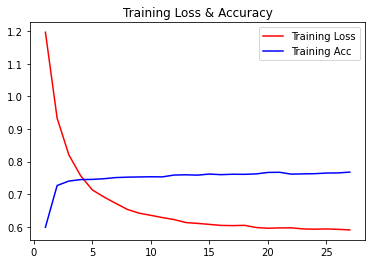

<Figure size 432x288 with 0 Axes>

In [ ]:
plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,acc,'b',label='Training Acc')
plt.title('Training Loss & Accuracy')
plt.legend()
plt.figure()

In [17]:
# 테스트데이터에 대해 모형 예측
y_pred_proba = model.predict(X_test)

# 결과값에 대해서 binary로 변환
mlp_clf_proba=1-y_pred_proba[:,0]

In [18]:
mlp_clf_proba

array([0.8777493 , 0.26972198, 0.49626726, ..., 0.7489138 , 0.46983916,
       0.3116396 ], dtype=float32)

In [19]:
sum(mlp_clf_proba>0.5)

2906

In [ ]:
############################################### mlp_clf_proba 변수에, MLP를 test에 적합하고 나온 확률값들이 들어가있다. ###############################################

## 4) 모형 앙상블

In [32]:
# x = lgbm_clf_proba + cat_clf_proba+mlp_clf_proba) / 3 # 83.323
x= lgbm_clf_proba * 0.5 + cat_clf_proba * 0.2 + mlp_clf_proba * 0.3 # 83.362 O(현재 최고 -5lgbm,2cat,3mlp(3129))


In [33]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x

In [34]:
sum(x>0.5)

3129

In [31]:
# 제출파일
sample_submssion.to_csv(os.path.join(current_day,tp,"70lgbm,15cat,15mlp (3185).csv"), index = False)
sample_submssion

,user_id,problem
0,30000,0.885613
1,30001,0.202388
2,30002,0.555989
3,30003,0.783800
4,30004,0.779343
...,...,...
14994,44994,0.245566
14995,44995,0.233111
14996,44996,0.755672
14997,44997,0.807107
